In [1]:
# TODO
# p-value / statistic
# finalize plot


import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from plotting import mimic_r_boxplot

from data_loading import (load_y2h_isoform_data, 
    load_m1h_activation_data, 
    load_ppi_partner_categories, 
    load_valid_isoform_clones,
    load_human_tf_db,
    load_y1h_pdi_data,
    load_ref_vs_alt_isoforms_table,
    load_annotated_6k_collection)
from data_loading.isoform_pairwise_metrics import _add_PPI_columns

In [2]:
pd.set_option('display.max_columns', 100)

In [3]:
y2h = load_y2h_isoform_data()
m1h = load_m1h_activation_data()
cats = load_ppi_partner_categories()

In [4]:
# TODO: move to data_loading
cof = pd.read_csv('../data/external/AnimalTFDB3_Homo_sapiens_TF_cofactors.txt',
                 sep='\t')
if cof['Symbol'].duplicated().any():
    raise UserWarning('unexpected duplicates')

In [5]:
cof.tail()

,Species,Symbol,Ensembl,Family,Entrez ID
1020,Homo_sapiens,TAF9,ENSG00000273841,TATA-box,6880
1021,Homo_sapiens,MLLT6,ENSG00000275023,Others,4302
1022,Homo_sapiens,AATF,ENSG00000275700,Others,26574
1023,Homo_sapiens,PCGF2,ENSG00000277258,PCGF,7703
1024,Homo_sapiens,PAGR1,ENSG00000280789,Others,79447


In [6]:
y2h.head()

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result
0,ATF2|1/6|12H04,ATF2,ATF2,True
3,ATF2|1/6|12H04,ATF2,FOSL2,NaN
4,ATF2|1/6|12H04,ATF2,JDP2,True
12,ATF2|2/6|09E05,ATF2,ATF2,True
15,ATF2|2/6|09E05,ATF2,FOSL2,NaN


In [7]:
# number of cofactors
# number of PPI with cofactors
# split by family
print(cof.shape[0], 'cofactors')
print(y2h.loc[y2h['db_gene_symbol'].isin(cof['Symbol']), 'db_gene_symbol'].nunique(),
      ' of which we have PPIs for')
print(y2h['db_gene_symbol'].isin(cof['Symbol']).sum(),
      ' cofactor PPIs')
cof_with_ppi = set(y2h.loc[y2h['db_gene_symbol'].isin(cof['Symbol']), 'db_gene_symbol'].unique())
print(cof.loc[cof['Symbol'].isin(cof_with_ppi), 'Family'].value_counts())

1025 cofactors
63  of which we have PPIs for
465  cofactor PPIs
Others                      29
Other_CRF                    4
LIM                          3
Cyclin                       2
Vestigial like               2
Ring finger protein          2
Histone deacetylase          2
WD                           1
MAGE                         1
Lysine acetyltransferase     1
TEF                          1
NFKB associated              1
HNRNP                        1
Chromobox                    1
Tripartite motif             1
SSX                          1
DPF                          1
INO80 complex                1
FHL                          1
SMYD                         1
TATA-box                     1
PHF                          1
Mediator complex             1
Bromodomain                  1
WW                           1
RNA helicase                 1
Name: Family, dtype: int64


In [8]:
df = pd.read_excel('../data/external/Geiger-et-al_MCP_2012_Supplementary-Table-2.xlsx',
                   skiprows=1)
hek_avrg = df[['iBAQ HEK293_1', 'iBAQ HEK293_2', 'iBAQ HEK293_3']].mean(axis=1)
print((hek_avrg > 0).sum(), 'proteins expressed in HEK293 proteome')
hek_expressed_genes = set(df.loc[(hek_avrg > 0) & df['Gene Names'].notnull(),
       'Gene Names'].str.split(';').explode().values)
all_partners = set(y2h['db_gene_symbol'].unique())
print('of {} PPI partners, {} are expressed in HEK293 cells'.format(len(all_partners), 
      len(all_partners.intersection(hek_expressed_genes))))


8543 proteins expressed in HEK293 proteome
of 500 PPI partners, 252 are expressed in HEK293 cells


In [9]:
pairs = load_ref_vs_alt_isoforms_table()
tfs = load_annotated_6k_collection()


def add_restricted_ppi_columns(pairs, rows, label):
    pairs_cf = pairs[['clone_acc_ref', 'clone_acc_alt']].copy()
    _add_PPI_columns(df=pairs_cf, y2h=y2h.loc[rows, :])
    return pd.merge(pairs, 
                    pairs_cf,
                    how='left',
                    on=['clone_acc_ref', 'clone_acc_alt'],
                    suffixes=('', '_' + label))


cofactor_partners = set(cats.loc[cats['category'] == 'cofactor', 'partner'].unique())
coactivator_partners = set(cats.loc[cats['cofactor_type'] == 'coactivator', 'partner'].unique())
corepressor_partners = set(cats.loc[cats['cofactor_type'] == 'corepressor', 'partner'].unique())
cofactor_animal_db = set(cof['Symbol'].unique())
tf_gene_symbols = set(load_human_tf_db()['HGNC symbol'].values)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(cofactor_partners),
                           label='cofactors'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(cofactor_animal_db),
                           label='cofactors_animal_db'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(coactivator_partners) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='coactivators_HEK'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(coactivator_partners) &
                                 ~y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='coactivators_not_HEK'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=~y2h['db_gene_symbol'].isin(cofactor_partners),
                           label='not_cofactors'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(coactivator_partners),
                           label='coactivators'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(corepressor_partners),
                           label='corepressors'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(corepressor_partners) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='corepressors_HEK'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(tf_gene_symbols),
                           label='tfs'
)

reading from cache


In [10]:
pairs['activation_abs_fold_change'] = pairs['activation_fold_change_log2'].abs()

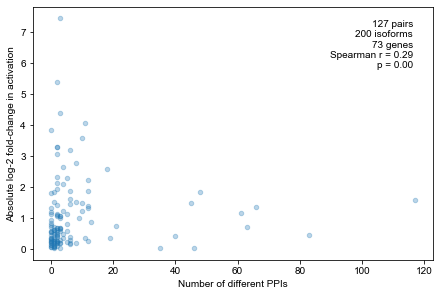

In [11]:
def scatter_with_correlation(x, y, pairs=pairs, x_label=None, y_label=None):
    """
    TODO:
        - calculate p-value properly
            - this requires permuting in some smart way
            - one question is whether the genes are the number of independent data points or the isoforms are
            - I think the answer is the isoforms are
    
    """
    if x_label is None:
        x_label = x
    if y_label is None:
        y_label = y
    fig, ax = plt.subplots(1, 1)
    pairs.plot.scatter(x=x, y=y, ax=ax, alpha=0.3)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    with_data = (pairs[x].notnull() & pairs[y].notnull())
    n_pair = with_data.sum()
    n_iso = len(set(pairs.loc[with_data, ['clone_acc_ref', 'clone_acc_alt']].values.flatten()))
    n_gene = pairs.loc[with_data, 'gene_symbol'].nunique()
    scc, p_scc = stats.spearmanr(pairs.loc[pairs[x].notnull() & pairs[y].notnull(), x].values,
                    pairs.loc[pairs[x].notnull() & pairs[y].notnull(), y].values)
    ax.text(s=f'{n_pair:d} pairs\n{n_iso:d} isoforms\n{n_gene:d} genes\nSpearman r = {scc:.2f}\np = {p_scc:.2f}',
            x=0.95,
            y=0.95,
            ha='right',
            va='top',
            transform=ax.transAxes)
    fig.savefig(f'../figures/{x}-vs-{y}_scatter.pdf',
                bbox_inches='tight')

scatter_with_correlation(
    x='n_PPI_diff',
    y='activation_abs_fold_change',
    x_label='Number of different PPIs',
    y_label='Absolute log-2 fold-change in activation')

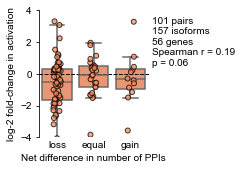

In [12]:
def bar_activation_vs_ppi(x, y, pairs=pairs, x_label=None, y_label=None, color=None):
    """
    TODO:
        - calculate p-value properly
            - this requires permuting in some smart way
            - one question is whether the genes are the number of independent data points or the isoforms are
            - I think the answer is the isoforms are
    
    """
    df = pairs.copy()
    if x_label is None:
        x_label = x
    if y_label is None:
        y_label = y
    if color is None:
        color = sns.color_palette("Set2")[1]
    fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.25))

    def bin_delta_ppi(delta_ppi):
        if pd.isnull(delta_ppi):
            return np.nan
        if delta_ppi < 0:
            return 'loss'
        elif delta_ppi > 0:
            return 'gain'
        elif delta_ppi == 0:
            return 'equal'
        else:
            raise ValueError(delta_ppi)


    df[x + '_binned'] = df[x].apply(bin_delta_ppi)
    sns.stripplot(data=df,
                  x=x + '_binned',
                  y=y,
                  order=['loss', 'equal', 'gain'],
                  alpha=0.75,
                  color=color,
                  linewidth=1,
                  edgecolor="black",
                  ax=ax)
    if False:
        sns.pointplot(data=df,
                    x=x + '_binned',
                    y=y,
                    order=['loss', 'equal', 'gain'],
                    alpha=0.5,
                    color='black',
                    ax=ax)
    if True:
        sns.boxplot(data=df,
                    x=x + '_binned',
                    y=y,
                    order=['loss', 'equal', 'gain'],
                    fliersize=0,
                    color=color,
                    ax=ax)
        mimic_r_boxplot(ax)
    else:
        sns.violinplot(data=df,
                    x=x + '_binned',
                    y=y,
                    order=['loss', 'equal', 'gain'],
                    color='lightgrey',
                    ax=ax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    with_data = (df[x].notnull() & df[y].notnull())
    n_pair = with_data.sum()
    n_iso = len(set(df.loc[with_data, ['clone_acc_ref', 'clone_acc_alt']].values.flatten()))
    n_gene = df.loc[with_data, 'gene_symbol'].nunique()
    scc, p_scc = stats.spearmanr(df.loc[df[x].notnull() & df[y].notnull(), x].values,
                    df.loc[df[x].notnull() & df[y].notnull(), y].values)
    ax.text(s=f'{n_pair:d} pairs\n{n_iso:d} isoforms\n{n_gene:d} genes\nSpearman r = {scc:.2f}\np = {p_scc:.2f}',
            x=1.03,
            y=0.95,
            ha='left',
            va='top',
            transform=ax.transAxes)
    ax.set_ylim(-4, 4) # NOTE cuts outlier TODO add broken axis
    ax.axhline(y=0, color='black', linestyle="dashed", linewidth=1)
    for pos in ['top', 'bottom', 'right']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    fig.savefig(f'../figures/{x}-vs-{y}_scatter.pdf',
                bbox_inches='tight')

bar_activation_vs_ppi(
    pairs=pairs.loc[pairs['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n',
    y='activation_fold_change_log2',
    x_label='Net difference in number of PPIs',
    y_label='log-2 fold-change in activation')

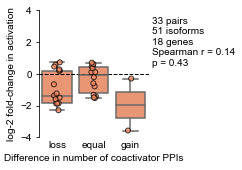

In [13]:
bar_activation_vs_ppi(
    pairs=pairs.loc[pairs['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_coactivators',
    y='activation_fold_change_log2',
    x_label='Difference in number of coactivator PPIs',
    y_label='log-2 fold-change in activation')

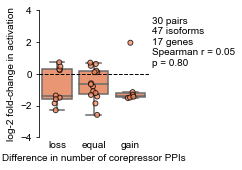

In [14]:
bar_activation_vs_ppi(
    pairs=pairs.loc[pairs['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_corepressors',
    y='activation_fold_change_log2',
    x_label='Difference in number of corepressor PPIs',
    y_label='log-2 fold-change in activation')

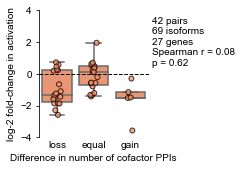

In [15]:
bar_activation_vs_ppi(
    pairs=pairs.loc[pairs['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_cofactors_animal_db',
    y='activation_fold_change_log2',
    x_label='Difference in number of cofactor PPIs',
    y_label='log-2 fold-change in activation')

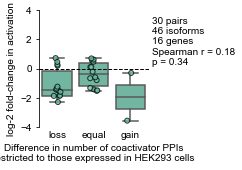

In [16]:
bar_activation_vs_ppi(
    pairs=pairs.loc[pairs['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_coactivators_HEK',
    y='activation_fold_change_log2',
    x_label='Difference in number of coactivator PPIs\nrestricted to those expressed in HEK293 cells',
    y_label='log-2 fold-change in activation',
    color=sns.color_palette("Set2")[0])

In [17]:
# TEST what is the outlier on the left
(pairs.loc[(pairs['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True)
           & (pairs['PPI_delta_n_coactivators_HEK'].notnull()), 
              :]
           .sort_values('activation_fold_change_log2',
                        ascending=False)).head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,n_PPI_diff,PPI_delta_n,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,...,n_shared_PPI_coactivators_not_HEK,n_PPI_diff_coactivators_not_HEK,PPI_delta_n_coactivators_not_HEK,PPI_jaccard_coactivators_not_HEK,n_positive_PPI_ref_not_cofactors,n_positive_PPI_alt_not_cofactors,n_PPI_successfully_tested_in_ref_and_alt_not_cofactors,n_positive_PPI_ref_filtered_not_cofactors,n_positive_PPI_alt_filtered_not_cofactors,n_shared_PPI_not_cofactors,n_PPI_diff_not_cofactors,PPI_delta_n_not_cofactors,PPI_jaccard_not_cofactors,n_positive_PPI_ref_coactivators,n_positive_PPI_alt_coactivators,n_PPI_successfully_tested_in_ref_and_alt_coactivators,n_positive_PPI_ref_filtered_coactivators,n_positive_PPI_alt_filtered_coactivators,n_shared_PPI_coactivators,n_PPI_diff_coactivators,PPI_delta_n_coactivators,PPI_jaccard_coactivators,n_positive_PPI_ref_corepressors,n_positive_PPI_alt_corepressors,n_PPI_successfully_tested_in_ref_and_alt_corepressors,n_positive_PPI_ref_filtered_corepressors,n_positive_PPI_alt_filtered_corepressors,n_shared_PPI_corepressors,n_PPI_diff_corepressors,PPI_delta_n_corepressors,PPI_jaccard_corepressors,n_positive_PPI_ref_corepressors_HEK,n_positive_PPI_alt_corepressors_HEK,n_PPI_successfully_tested_in_ref_and_alt_corepressors_HEK,n_positive_PPI_ref_filtered_corepressors_HEK,n_positive_PPI_alt_filtered_corepressors_HEK,n_shared_PPI_corepressors_HEK,n_PPI_diff_corepressors_HEK,PPI_delta_n_corepressors_HEK,PPI_jaccard_corepressors_HEK,n_positive_PPI_ref_tfs,n_positive_PPI_alt_tfs,n_PPI_successfully_tested_in_ref_and_alt_tfs,n_positive_PPI_ref_filtered_tfs,n_positive_PPI_alt_filtered_tfs,n_shared_PPI_tfs,n_PPI_diff_tfs,PPI_delta_n_tfs,PPI_jaccard_tfs,activation_abs_fold_change
359,TCF4,ENSG00000196628,bHLH,True,TCF4|1/9|07E01,TCF4|7/9|07G03,ENST00000354452|ENST00000629387,NaN,False,True,True,671,511,18,12,True,False,False,False,False,False,False,False,0.0,0.0,False,72.6,156.0,95.0,155.0,155.0,92.0,92.0,63.0,-63.0,0.593548,retains all,loses some,loses some,loses some,loses some,20.0,NaN,NaN,NaN,NaN,NaN,NaN,True,3.705451,...,1.0,2.0,-2.0,0.333333,136.0,85.0,135.0,135.0,82.0,82.0,53.0,-53.0,0.607407,8.0,3.0,8.0,8.0,3.0,3.0,5.0,-5.0,0.375,6.0,3.0,6.0,6.0,3.0,3.0,3.0,-3.0,0.5,3.0,2.0,3.0,3.0,2.0,2.0,1.0,-1.0,0.666667,25.0,22.0,25.0,25.0,22.0,22.0,3.0,-3.0,0.880000,0.721583
356,TCF4,ENSG00000196628,bHLH,True,TCF4|1/9|07E01,TCF4|4/9|07G02,ENST00000354452|ENST00000629387,NaN,False,True,True,671,666,18,18,False,False,False,True,True,False,False,False,0.0,0.0,False,99.3,156.0,155.0,155.0,155.0,153.0,153.0,2.0,-2.0,0.987097,retains all,loses some,loses some,retains all,retains all,20.0,13.0,20.0,20.0,13.0,13.0,0.65,True,3.705451,...,3.0,0.0,0.0,1.000000,136.0,135.0,135.0,135.0,133.0,133.0,2.0,-2.0,0.985185,8.0,8.0,8.0,8.0,8.0,8.0,0.0,0.0,1.000,6.0,6.0,6.0,6.0,6.0,6.0,0.0,0.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,1.000000,25.0,23.0,24.0,24.0,23.0,23.0,1.0,-1.0,0.958333,0.699990
355,TCF4,ENSG00000196628,bHLH,True,TCF4|1/9|07E01,TCF4|3/9|07C04,ENST00000354452|ENST00000629387,ENST00000356073|ENST00000564999,False,False,True,671,667

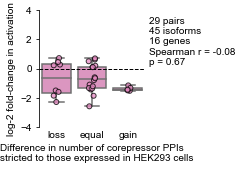

In [18]:
bar_activation_vs_ppi(
    pairs=pairs.loc[pairs['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_corepressors_HEK',
    y='activation_fold_change_log2',
    x_label='Difference in number of corepressor PPIs\nrestricted to those expressed in HEK293 cells',
    y_label='log-2 fold-change in activation',
    color=sns.color_palette("Set2")[3])

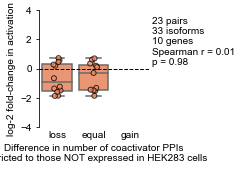

In [19]:
# this is not correct
# what I want is the pairs where all the lost cofactors are not expressed
bar_activation_vs_ppi(
    pairs=pairs.loc[pairs['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_coactivators_not_HEK',
    y='activation_fold_change_log2',
    x_label='Difference in number of coactivator PPIs\nrestricted to those NOT expressed in HEK283 cells',
    y_label='log-2 fold-change in activation')

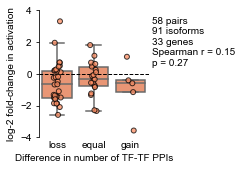

In [20]:
bar_activation_vs_ppi(
    pairs=pairs.loc[pairs['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_tfs',
    y='activation_fold_change_log2',
    x_label='Difference in number of TF-TF PPIs',
    y_label='log-2 fold-change in activation')

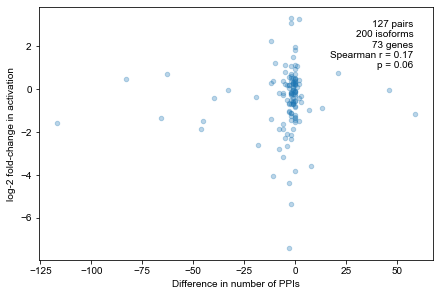

In [21]:
scatter_with_correlation(
    x='PPI_delta_n',
    y='activation_fold_change_log2',
    x_label='Difference in number of PPIs',
    y_label='log-2 fold-change in activation')

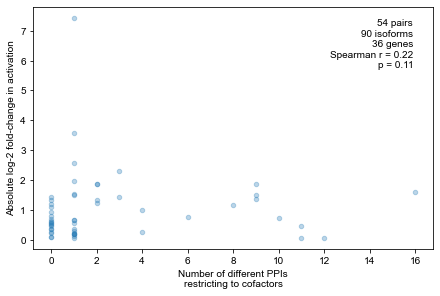

In [22]:
scatter_with_correlation(
    x='n_PPI_diff_cofactors',
    y='activation_abs_fold_change',
    x_label='Number of different PPIs\nrestricting to cofactors',
    y_label='Absolute log-2 fold-change in activation')

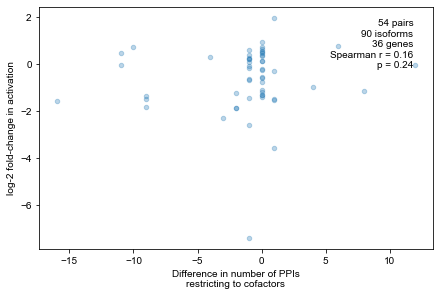

In [23]:
scatter_with_correlation(
    x='PPI_delta_n_cofactors',
    y='activation_fold_change_log2',
    x_label='Difference in number of PPIs\nrestricting to cofactors',
    y_label='log-2 fold-change in activation')

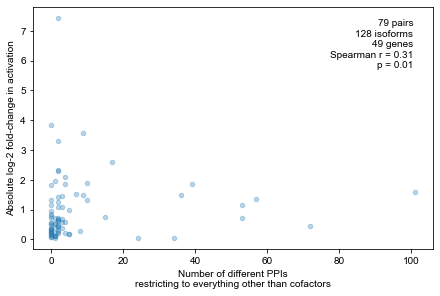

In [26]:
scatter_with_correlation(
    x='n_PPI_diff_not_cofactors',
    y='activation_abs_fold_change',
    x_label='Number of different PPIs\nrestricting to everything other than cofactors',
    y_label='Absolute log-2 fold-change in activation')

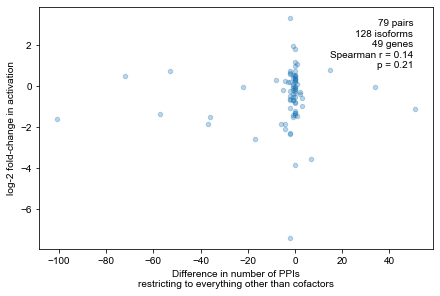

In [27]:
scatter_with_correlation(
    x='PPI_delta_n_not_cofactors',
    y='activation_fold_change_log2',
    x_label='Difference in number of PPIs\nrestricting to everything other than cofactors',
    y_label='log-2 fold-change in activation')

In [30]:
pairs.loc[(pairs['n_PPI_successfully_tested_in_ref_and_alt_coactivators'] >= 1) & (pairs['n_PPI_diff_cofactors'] == 0), :]

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,n_PPI_diff,PPI_delta_n,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,...,n_shared_PPI_coactivators_not_HEK,n_PPI_diff_coactivators_not_HEK,PPI_delta_n_coactivators_not_HEK,PPI_jaccard_coactivators_not_HEK,n_positive_PPI_ref_not_cofactors,n_positive_PPI_alt_not_cofactors,n_PPI_successfully_tested_in_ref_and_alt_not_cofactors,n_positive_PPI_ref_filtered_not_cofactors,n_positive_PPI_alt_filtered_not_cofactors,n_shared_PPI_not_cofactors,n_PPI_diff_not_cofactors,PPI_delta_n_not_cofactors,PPI_jaccard_not_cofactors,n_positive_PPI_ref_coactivators,n_positive_PPI_alt_coactivators,n_PPI_successfully_tested_in_ref_and_alt_coactivators,n_positive_PPI_ref_filtered_coactivators,n_positive_PPI_alt_filtered_coactivators,n_shared_PPI_coactivators,n_PPI_diff_coactivators,PPI_delta_n_coactivators,PPI_jaccard_coactivators,n_positive_PPI_ref_corepressors,n_positive_PPI_alt_corepressors,n_PPI_successfully_tested_in_ref_and_alt_corepressors,n_positive_PPI_ref_filtered_corepressors,n_positive_PPI_alt_filtered_corepressors,n_shared_PPI_corepressors,n_PPI_diff_corepressors,PPI_delta_n_corepressors,PPI_jaccard_corepressors,n_positive_PPI_ref_corepressors_HEK,n_positive_PPI_alt_corepressors_HEK,n_PPI_successfully_tested_in_ref_and_alt_corepressors_HEK,n_positive_PPI_ref_filtered_corepressors_HEK,n_positive_PPI_alt_filtered_corepressors_HEK,n_shared_PPI_corepressors_HEK,n_PPI_diff_corepressors_HEK,PPI_delta_n_corepressors_HEK,PPI_jaccard_corepressors_HEK,n_positive_PPI_ref_tfs,n_positive_PPI_alt_tfs,n_PPI_successfully_tested_in_ref_and_alt_tfs,n_positive_PPI_ref_filtered_tfs,n_positive_PPI_alt_filtered_tfs,n_shared_PPI_tfs,n_PPI_diff_tfs,PPI_delta_n_tfs,PPI_jaccard_tfs,activation_abs_fold_change
18,LHX9,ENSG00000143355,Homeodomain,False,LHX9|1/3|06C10,LHX9|2/3|06D10,ENST00000367387,NaN,False,True,True,397,396,5,5,False,False,False,False,True,False,False,False,0.0,0.000000,False,99.7,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,1.000000,NaN,retains all,retains all,retains all,NaN,0.0,3.0,3.0,0.0,3.0,0.0,0.00,True,3.173406,...,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.000000,0.791181
19,LHX9,ENSG00000143355,Homeodomain,False,LHX9|1/3|06C10,LHX9|3/3|07A01,ENST00000367387,ENST00000367390,False,False,True,397,388,5,6,True,False,False,False,True,False,False,False,0.0,0.000000,False,96.0,4.0,3.0,4.0,4.0,3.0,3.0,1.0,-1.0,0.750000,NaN,loses some,loses all,retains all,NaN,0.0,6.0,6.0,0.0,6.0,0.0,0.00,True,3.173406,...,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1.0,0.0,0.0,1.0,-1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,-1.0,0.000000,0.102355
54,NFE2L2,ENSG00000116044,bZIP,True,NFE2L2|1/3|12H08,NFE2L2|2/3|01F05,ENST00000397062,ENST00000397063|ENST00000464747,False,False,True,605,589,5,4,True,False,False,False,True,False,False,False,0.0,0.000000,False,97.4,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,1.000000,retains all,retain

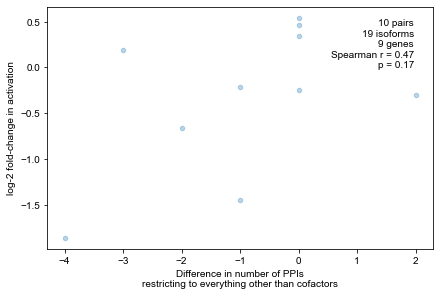

In [34]:
# restrict to no change with cofactors
# BUG: file name could overwrite?
scatter_with_correlation(
    pairs=pairs.loc[(pairs['n_PPI_successfully_tested_in_ref_and_alt_coactivators'] >= 1) & (pairs['n_shared_PPI_cofactors'] == pairs['n_PPI_successfully_tested_in_ref_and_alt_coactivators']), :],
    x='PPI_delta_n_not_cofactors',
    y='activation_fold_change_log2',
    x_label='Difference in number of PPIs\nrestricting to everything other than cofactors',
    y_label='log-2 fold-change in activation')

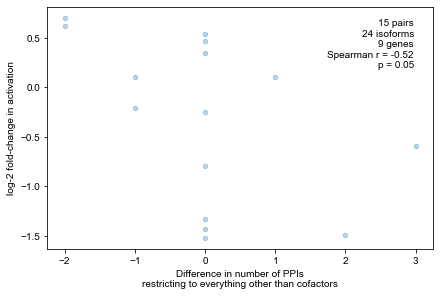

In [38]:
scatter_with_correlation(
    pairs=pairs.loc[(pairs['n_PPI_diff_coactivators'] == 0), :],
    x='PPI_delta_n',
    y='activation_fold_change_log2',
    x_label='Difference in number of PPIs\nrestricting to everything other than cofactors',
    y_label='log-2 fold-change in activation')

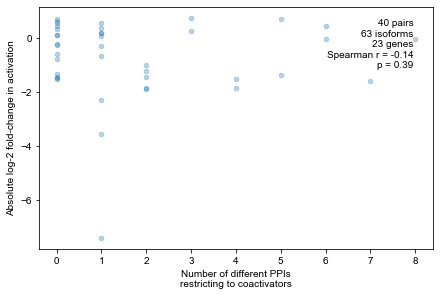

In [40]:
scatter_with_correlation(
    x='n_PPI_diff_coactivators',
    y='activation_fold_change_log2',
    x_label='Number of different PPIs\nrestricting to coactivators',
    y_label='Absolute log-2 fold-change in activation')

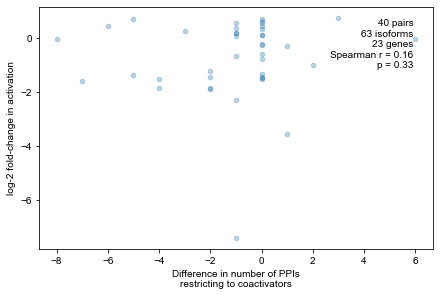

In [41]:
scatter_with_correlation(
    x='PPI_delta_n_coactivators',
    y='activation_fold_change_log2',
    x_label='Difference in number of PPIs\nrestricting to coactivators',
    y_label='log-2 fold-change in activation')

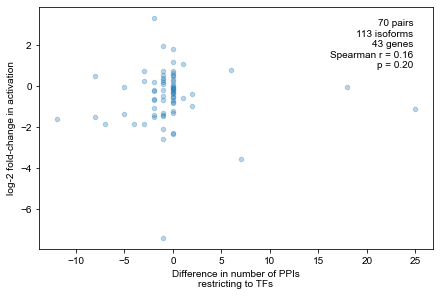

In [43]:
scatter_with_correlation(
    x='PPI_delta_n_tfs',
    y='activation_fold_change_log2',
    x_label='Difference in number of PPIs\nrestricting to TFs',
    y_label='log-2 fold-change in activation')

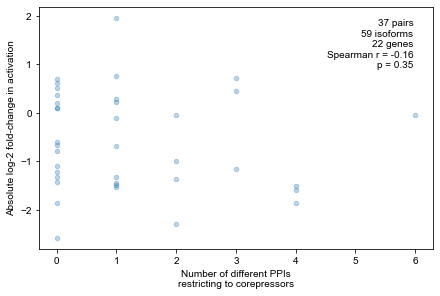

In [45]:
scatter_with_correlation(
    x='n_PPI_diff_corepressors',
    y='activation_fold_change_log2',
    x_label='Number of different PPIs\nrestricting to corepressors',
    y_label='Absolute log-2 fold-change in activation')

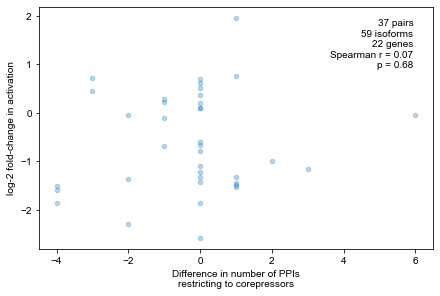

In [46]:
scatter_with_correlation(
    x='PPI_delta_n_corepressors',
    y='activation_fold_change_log2',
    x_label='Difference in number of PPIs\nrestricting to corepressors',
    y_label='log-2 fold-change in activation')

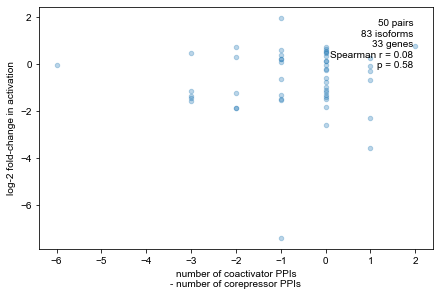

In [47]:
# co-repressors minus coactivators
pairs['PPI_delta_n_coactivators_minus_corepressors'] = pairs['PPI_delta_n_coactivators'].fillna(0) - pairs['PPI_delta_n_corepressors'].fillna(0)
pairs.loc[pairs['PPI_delta_n_coactivators'].isnull() & pairs['PPI_delta_n_corepressors'].isnull(),
          'PPI_delta_n_coactivators_minus_corepressors'] = np.nan
scatter_with_correlation(
    x='PPI_delta_n_coactivators_minus_corepressors',
    y='activation_fold_change_log2',
    x_label='number of coactivator PPIs\n- number of corepressor PPIs',
    y_label='log-2 fold-change in activation')

In [51]:
# look at the biggest difference examples
(pairs.loc[pairs['n_PPI_diff'] > 0, 
['gene_symbol', 'clone_acc_ref', 'clone_acc_alt', 'activation_abs_fold_change', 'n_PPI_successfully_tested_in_ref_and_alt', 'n_PPI_diff', 'n_PPI_diff_cofactors']]
.sort_values('activation_abs_fold_change', ascending=False).head(25)
)

,gene_symbol,clone_acc_ref,clone_acc_alt,activation_abs_fold_change,n_PPI_successfully_tested_in_ref_and_alt,n_PPI_diff,n_PPI_diff_cofactors
127,E2F3,E2F3|2/4|10A08,E2F3|3/4|10B08,7.433645,5.0,3.0,1.0
240,FOXJ2,FOXJ2|1/2|06F10,FOXJ2|2/2|06B11,5.383136,2.0,2.0,NaN
222,CREBZF,CREBZF|1/2|04B03,CREBZF|2/2|04C04,4.377453,3.0,3.0,NaN
305,ZNF263,ZNF263|1/3|11C01,ZNF263|3/3|05A08,4.057763,11.0,11.0,NaN
415,ZSCAN18,ZSCAN18|2/7|09A01,ZSCAN18|1/7|09F02,3.572874,10.0,10.0,1.0
50,ATF2,ATF2|1/6|12H04,ATF2|5/6|09A05,3.306912,3.0,2.0,NaN
97,ELF2,ELF2|2/4|04E01,ELF2|1/4|03A11,3.280586,2.0,2.0,NaN
69,PPARG,PPARG|1/4|10G02,PPARG|3/4|01H02,3.180428,6.0,6.0,NaN
46,E2F6,E2F6|1/2|10C02,E2F6|2/2|01A04,3.075493,2.0,2.0,NaN
363,FOSB,FOSB|1/3|05D03,FOSB|3/3|05G04,2.788988,8.0,8.0,NaN


In [54]:
# look for repression differences
(pairs.loc[(pairs['n_PPI_diff'] > 0) & pairs['gene_symbol'].isin(m1h.loc[(m1h['M1H_rep1'] < -1), 'gene'].unique()), 
['gene_symbol', 'clone_acc_ref', 'clone_acc_alt', 'activation_abs_fold_change', 'n_PPI_successfully_tested_in_ref_and_alt', 'n_PPI_diff', 'n_PPI_diff_cofactors']]
.sort_values('activation_abs_fold_change', ascending=False).head(25)
)

,gene_symbol,clone_acc_ref,clone_acc_alt,activation_abs_fold_change,n_PPI_successfully_tested_in_ref_and_alt,n_PPI_diff,n_PPI_diff_cofactors
226,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|3/9|10B06,1.525376,15.0,8.0,1.0
228,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|5/9|10H05,1.493713,17.0,10.0,1.0
229,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|6/9|12H02,1.445209,12.0,6.0,3.0
227,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|4/9|10H06,1.324958,17.0,12.0,2.0
116,PPARD,PPARD|1/3|04F06,PPARD|2/3|04G07,1.077391,3.0,3.0,NaN
117,PPARD,PPARD|1/3|04F06,PPARD|3/3|04H07,1.007009,3.0,3.0,NaN
250,RFX4,RFX4|1/3|10C04,RFX4|2/3|10D02,0.660592,8.0,3.0,1.0
225,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|2/9|10F05,0.362092,11.0,11.0,NaN
38,MEIS1,MEIS1|1/2|09A04,MEIS1|2/2|09G04,0.289846,6.0,6.0,NaN
251,RFX4,RFX4|1/3|10C04,RFX4|3/3|12B07,0.194373,8.0,8.0,NaN


MannwhitneyuResult(statistic=nan, pvalue=nan)

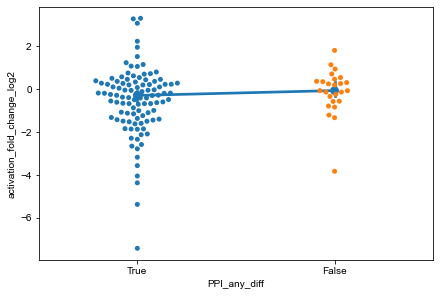

In [57]:
# do category plot on some vs no difference
pairs['PPI_any_diff'] = (pairs['n_PPI_diff'] != 0)
pairs.loc[pairs['n_PPI_diff'].isnull(), 'PPI_any_diff'] = np.nan
x = 'PPI_any_diff'
y = 'activation_fold_change_log2'
sns.swarmplot(data=pairs, x='PPI_any_diff', y='activation_fold_change_log2')
sns.pointplot(data=pairs, x='PPI_any_diff', y='activation_fold_change_log2', estimator=np.median)
stats.mannwhitneyu(pairs.loc[pairs[x] == True, y], pairs.loc[pairs[x] == False, y])

In [58]:
pairs['n_PPI_diff'].value_counts().sum()

155

In [59]:
pairs['PPI_any_diff'].value_counts()

True     124
False     31
Name: PPI_any_diff, dtype: int64

MannwhitneyuResult(statistic=nan, pvalue=nan)

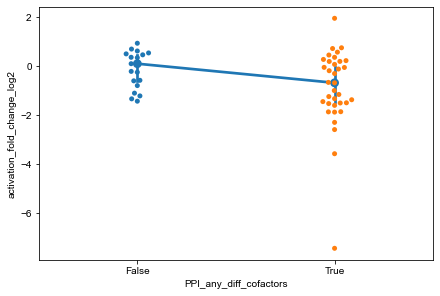

In [60]:
pairs['PPI_any_diff_cofactors'] = pairs['n_PPI_diff_cofactors'] != 0
pairs.loc[pairs['n_PPI_diff_cofactors'].isnull(), 'PPI_any_diff_cofactors'] = np.nan
x = 'PPI_any_diff_cofactors'
y = 'activation_fold_change_log2'
sns.swarmplot(data=pairs, x='PPI_any_diff_cofactors', y='activation_fold_change_log2')
sns.pointplot(data=pairs, x='PPI_any_diff_cofactors', y='activation_fold_change_log2', estimator=np.median)
stats.mannwhitneyu(pairs.loc[pairs[x] == True, y], pairs.loc[pairs[x] == False, y])

MannwhitneyuResult(statistic=nan, pvalue=nan)

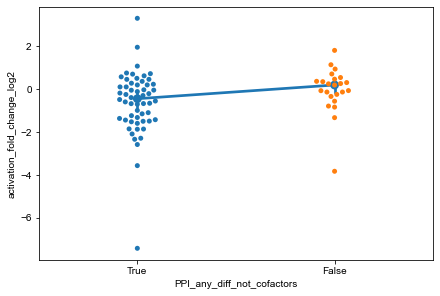

In [61]:
x = 'PPI_any_diff_not_cofactors'
y = 'activation_fold_change_log2'
pairs['PPI_any_diff_not_cofactors'] = pairs['n_PPI_diff_not_cofactors'] != 0
pairs.loc[pairs['n_PPI_diff_not_cofactors'].isnull(), 'PPI_any_diff_not_cofactors'] = np.nan
sns.swarmplot(data=pairs, x='PPI_any_diff_not_cofactors', y='activation_fold_change_log2')
sns.pointplot(data=pairs, x='PPI_any_diff_not_cofactors', y='activation_fold_change_log2', estimator=np.median)
stats.mannwhitneyu(pairs.loc[pairs[x] == True, y], pairs.loc[pairs[x] == False, y])

In [62]:
y2h.head()

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result
0,ATF2|1/6|12H04,ATF2,ATF2,True
3,ATF2|1/6|12H04,ATF2,FOSL2,NaN
4,ATF2|1/6|12H04,ATF2,JDP2,True
12,ATF2|2/6|09E05,ATF2,ATF2,True
15,ATF2|2/6|09E05,ATF2,FOSL2,NaN


In [63]:
# what is the best metric for PPI partners whose loss is most associciated with change in
# activation?

def ppi_tf_gene(data, gene_name):
    tf = data.loc[(data['ad_gene_symbol'] == gene_name),
                  ['ad_clone_acc', 'db_gene_symbol', 'Y2H_result']].copy()
    tf = tf.pivot(index='ad_clone_acc',
                  columns='db_gene_symbol',
                  values='Y2H_result')
    return tf

# for each tf, for each partner, if differentially bound, absolute change in activation
data = []
for tf_gene in y2h['ad_gene_symbol'].unique():
    tf_ppi = ppi_tf_gene(y2h, tf_gene)
    tf_ppi = tf_ppi.loc[tf_ppi.any(axis=1), :]
    if tf_ppi.shape[0] < 2:
        continue
    tf_ppi = tf_ppi.loc[:, (tf_ppi == True).any(axis=0) & (tf_ppi == False).any(axis=0)]
    for partner in tf_ppi.columns:
        binds = tf_ppi.index[tf_ppi[partner] == True].values
        not_binds = tf_ppi.index[tf_ppi[partner] == False].values
        actv_diff = (m1h.loc[m1h['clone_acc'].isin(binds), ['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean().mean()
                     - m1h.loc[m1h['clone_acc'].isin(not_binds), ['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean().mean())
        data.append([tf_gene, partner, actv_diff])
df = pd.DataFrame(data=data, columns=['tf_gene', 'partner', 'activation_diff']).dropna()
df['num_points'] = df['partner'].map(df['partner'].value_counts())
df = df.sort_values(['num_points', 'partner', 'activation_diff'], ascending=False)

In [64]:
df.head(12)

,tf_gene,partner,activation_diff,num_points
73,ZBTB44,ZNF417,1.447314,5
368,TCF4,ZNF417,0.803438,5
182,HMBOX1,ZNF417,0.228410,5
395,ESRRG,ZNF417,-1.955542,5
37,ZSCAN18,ZNF417,-3.572874,5
185,E2F3,PRKAA2,7.433645,5
420,FOSB,PRKAA2,2.293175,5
334,TCF4,PRKAA2,1.774368,5
29,NFYA,PRKAA2,0.834103,5
385,ZNF438,PRKAA2,0.752061,5


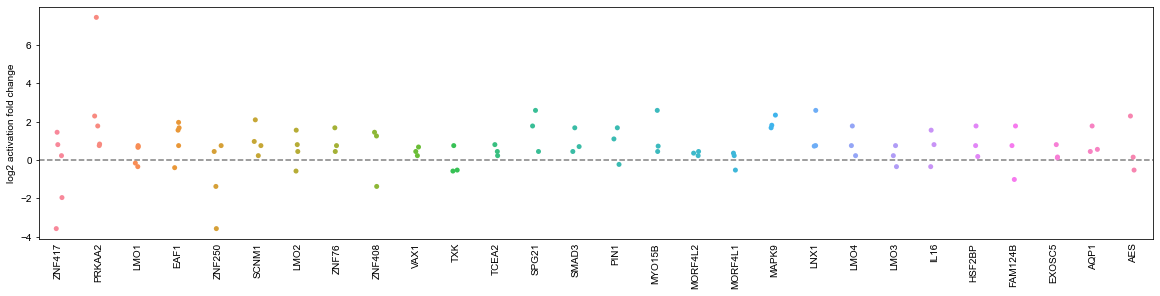

In [65]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 4)
sns.stripplot(data=df.loc[df['num_points'] > 2, :],
              x='partner',
              y='activation_diff',
              ax=ax)
ax.axhline(0, linestyle='--', color='grey')
ax.set_xlabel('')
ax.set_ylabel('log2 activation fold change')
ax.tick_params(axis='x', rotation=90, length=0)
plt.savefig('../figures/activation_change_per_ppi_partner.pdf',
            bbox_inches='tight')